In [1]:
import pandas as pd
import numpy as np
import NDCG as ndcg
import MHR as mhr
import sys
import types
ndcg.reload_package(mhr)
from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
%matplotlib inline

loading MHR


In [4]:
reviews_features = pd.read_csv('data/eletronic_sample_counts.csv.gz')
df_agg = reviews_features[['word_count','asin']].groupby(['asin']).agg(['count','mean'])
df_agg['word_count'].sort_values('count',ascending=False).head(10)

,count,mean
asin,,
B00BGA9WK2,351,253.079772
B00A3YN0Z0,219,104.237443
B0074BW614,201,451.900498
B00CMQTVK0,165,334.696970
B0094NY3R0,147,232.972789
B0045FM6SU,140,374.121429
B00DVFLJDS,139,352.625899
B009LL9VDG,133,424.443609
B002C7481G,132,501.636364


In [5]:
#list_asin = ['B00BGA9WK2','B00A3YN0Z0','B0074BW614','B00CMQTVK0','B0094NY3R0','B0045FM6SU','B00DVFLJDS']
#reviews_features = reviews_features[reviews_features.asin.isin(list_asin)]
#reviews_features.drop('powerWithStar', axis=1, inplace=True)
#reviews_features,ndcg_mhr = mhr.executeFromDf(reviews_features)
reviews_features.shape
#reviews_features.to_csv('data/eletronic_sample_counts.csv.gz', compression='gzip')

product=1400532655 ndcg=0.877750740057 (0.877750740057)
product=B00000J061 ndcg=0.898998964071 (0.920247188085)
product=B00001P4ZH ndcg=0.906054259083 (0.920164849108)
product=B00001WRSJ ndcg=0.888379604806 (0.835355641976)
product=B000031KIM ndcg=0.90346357678 (0.963799464675)
product=B00004SB92 ndcg=0.902177224924 (0.895745465646)
product=B00004THCZ ndcg=0.910878737103 (0.963087810173)
product=B00004XOM3 ndcg=0.915771704627 (0.950022477297)
product=B00004ZCJE ndcg=0.913083368743 (0.891576681671)
product=B000053HC5 ndcg=0.903065789652 (0.812907577829)
product=B000053HH5 ndcg=0.901157597927 (0.882075680676)
product=B00005LEN4 ndcg=0.908486431965 (0.989103606389)
product=B000062VUO ndcg=0.899074092981 (0.786126025165)
product=B00006B7DA ndcg=0.9023528046 (0.944976055648)
product=B00006HMPK ndcg=0.90620616136 (0.960153156009)
product=B00006I53S ndcg=0.909770469077 (0.963235084833)
product=B00006I53X ndcg=0.908969048525 (0.896146319692)
product=B00006IS4X ndcg=0.907917073 (0.890033489071)

PageRank ndcg=0.87155497918
HITs ndcg=0.871770213457
MHR ndcg=0.89145328691
383
383
383


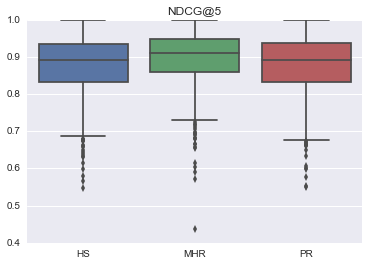

In [83]:
import seaborn as sns
k=5

ndcg_pr=calc_ndcg(reviews_features,'pageRank',k) 
corr_pr=calc_corr(reviews_features,'pageRank') 
print "PageRank ndcg="+str(np.mean(ndcg_pr))

ndcg_hs=calc_ndcg(reviews_features,'hits',k) 
corr_hs=calc_corr(reviews_features,'hits') 
print "HITs ndcg="+str(np.mean(ndcg_hs))

#ndcg_mhr=calc_ndcg(reviews_features,'powerWithStar',k) 
corr_mhr=calc_corr(reviews_features,'powerWithStar') 
print "MHR ndcg="+str(np.mean(ndcg_mhr))

print (len(ndcg_hs))
print (len(ndcg_pr))
print (len(ndcg_mhr))

tip={}
tip['HS']=ndcg_hs
tip['PR']=ndcg_pr
tip['MHR']=ndcg_mhr
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
#ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))

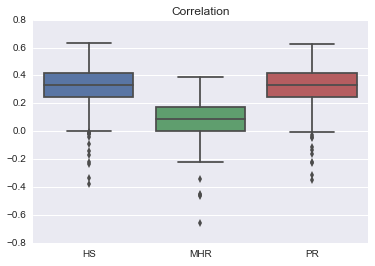

In [84]:
tip={}
tip['PR']=corr_pr
tip['HS']=corr_hs
tip['MHR']=corr_mhr
dftip=pd.DataFrame(tip)
dftip.head()
ax = sns.boxplot(data=dftip)
#ax = sns.swarmplot(data=dftip, color=".25")

ax.set_title('Correlation')